## Imports and variable/function definitions

In [1]:
from efaar_benchmarking.data_loading import *
from efaar_benchmarking.efaar import *
from efaar_benchmarking.benchmarking import *
from efaar_benchmarking.constants import *
import pandas as pd
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
from upsetplot import from_contents, UpSet
import pickle
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import combinations
from sklearn.cluster import AgglomerativeClustering
import numpy as np

res_folder = 'data'
expression_data_folder = '../efaar_benchmarking/expression_data'

pert_label_cols = {
    'GWPS': 'gene',
    'cpg0016': 'Metadata_Symbol',
    'cpg0021': 'Metadata_Foci_Barcode_MatchedTo_GeneCode',
}

control_cols = {
    'GWPS': ['non-targeting'],
    'cpg0016': ['non-targeting', 'no-guide'],
    'cpg0021': ['nontargeting', 'negCtrl'],
}

def sig_level(x):
    if np.isnan(x):
        return '-'
    elif x < 1e-5:
        return '*****'
    elif x < 1e-4:
        return '****'
    elif x < 1e-3:
        return '***'
    elif x < 1e-2:
        return '**'
    elif x < 0.05:
        return '*'
    else:
        return 'ns'

def plot_clustermap(maps, dataset, genes, save_path=None):
    pheno_data = maps[dataset]
    pert_colname = pert_label_cols[dataset]
    feat = pheno_data.features
    feat.index = pheno_data.metadata[pert_colname]
    genes = [x for x in genes if x in list(feat.index)]
    feat_genes = feat.loc[genes]
    cosi = cosine_similarity(feat_genes)
    cosi = pd.DataFrame(cosi, index=feat_genes.index, columns=feat_genes.index)
    sns.set_theme(font_scale=1)
    v = np.triu(cosi[genes].loc[genes])
    sns.clustermap(pd.DataFrame(v, columns=genes, index=genes), cmap='RdBu_r', vmin=-1, vmax=1, figsize=(5,5),
                   row_cluster=False, col_cluster=False, cbar_pos=(.1, .1, .005, .18))
    plt.savefig(save_path)

def plot_asym_clustermap(maps, datasets, genes, red_genes=[], save_path=None, cluster=False):
    genes2plot = genes
    for i, dataset in enumerate(datasets):
        pheno_data = maps[dataset]
        pert_colname = pert_label_cols[dataset]
        genes2plot = [x for x in genes2plot if x in list(pheno_data.metadata[pert_colname])]
    for i, dataset in enumerate(datasets):
        pheno_data = maps[dataset]
        pert_colname = pert_label_cols[dataset]
        feat = pheno_data.features
        feat.index = pheno_data.metadata[pert_colname]
        feat_genes = feat.loc[genes2plot]
        cosi = cosine_similarity(feat_genes)
        cosi = pd.DataFrame(cosi, index=feat_genes.index, columns=feat_genes.index)
        sns.set_theme(font_scale=2)
        if i == 0:
            if cluster:
                cg = sns.clustermap(cosi, cmap='RdBu_r', vmin=-1, vmax=1, yticklabels=True) # yticklabels=True because we use that info later for ordering
                ordering = list(cosi.index[cg.dendrogram_row.reordered_ind])
            else:
                cg = sns.clustermap(cosi, cmap='RdBu_r', vmin=-1, vmax=1, figsize=(30,30), row_cluster=False, col_cluster=False, cbar_pos=(.1, .1, .005, .18))
                ordering = list(cosi.index)
            plt.clf()
            u = np.tril(cosi[ordering].loc[ordering], k=-1)
        else:
            tmp = cosi[ordering].loc[ordering]
            v = np.triu(tmp)
            lbls = list(tmp.index) # needed when cluster=False and each gene in `genes` can be in multiple clusters
            cg = sns.clustermap(pd.DataFrame(u+v, columns=lbls, index=lbls), cmap='RdBu_r', vmin=-1, vmax=1, figsize=(30,30), row_cluster=False, col_cluster=False, cbar_pos=(.1, .1, .005, .18))
            if len(red_genes) > 0:
                for l in cg.ax_heatmap.yaxis.get_ticklabels():
                    if l.get_text() in red_genes:
                        l.set_color('red')
            cg.cax.set_visible(False)
            if save_path is not None:
                plt.savefig(save_path, bbox_inches='tight', pad_inches=0.01)
            plt.show()

def plot_heatmaps(all_pvals, datasets_to_plot, overlap_thr=0):
    df_plotting = all_pvals.copy()
    df_plotting = df_plotting.dropna(subset=[f'genes_{datasets_to_plot[0]}', f'genes_{datasets_to_plot[1]}'])
    df_plotting['overlap_plotting'] = df_plotting.apply(
        lambda row: sorted(set(row[f'genes_{datasets_to_plot[0]}']).intersection(row[f'genes_{datasets_to_plot[1]}'])), axis=1)
    clusters = {}
    for c,genes in df_plotting[['cluster', 'overlap_plotting']].itertuples(index=False):
        clusters[c] = genes
    clusters = dict(sorted(clusters.items(), key=lambda item: len(item[1])))
    clus_to_save = {}
    for i, (c, clus) in enumerate(clusters.items()):
        if i==0:
            clus_to_save[c] = clus
        else:
            for _, clus2 in clus_to_save.items():
                not_keep_flag = False
                if len(set(clus).intersection(clus2)) > overlap_thr:
                    not_keep_flag = True
                    break
            if not not_keep_flag:
                clus_to_save[c] = clus
    genes_to_plot = []
    for c, genes in clus_to_save.items():
        genes_to_plot += genes
    plot_asym_clustermap(maps, datasets_to_plot, genes_to_plot)

/Users/safiye.celik/.pyenv/versions/3.11.5/envs/eben/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/safiye.celik/.pyenv/versions/3.11.5/envs/eben/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Users/safiye.celik/.pyenv/versions/3.11.5/envs/eben/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the stored map data and all-sample metadata

In [2]:
metadatas = {}
maps = {}

for dataset in ['GWPS', 'cpg0016', 'cpg0021']:
    with open(f'data/{dataset}_map_cache.pkl', 'rb') as f:
        maps[dataset] = pickle.load(f)
    with open(f'{res_folder}/{dataset}_metadata.pkl', 'rb') as f:
        metadatas[dataset] = pickle.load(f)

## Check the number of genes and samples (for Table 1)

In [3]:
gwps_all_genes = set(metadatas['GWPS'][pert_label_cols['GWPS']])
print('GWPS gene count is', len(gwps_all_genes))
print('GWPS expressed gene count is', len(gwps_all_genes)) ## all genes are expressed in GWPS
print('GWPS sample size is', len(metadatas['GWPS']))
print('GWPS sample size excluding controls is', len(metadatas['GWPS'][~metadatas['GWPS'][pert_label_cols['GWPS']].isin(control_cols['GWPS'])]))

cpg16_all_genes = set(metadatas['cpg0016'][pert_label_cols['cpg0016']])
print('cpg0016', len(cpg16_all_genes))
expr = pd.read_csv(f'{expression_data_folder}/U2OS_expression.csv', index_col=0)
expr = expr.groupby('gene').zfpkm.agg('median').reset_index()
jump_exp_genes = cpg16_all_genes.intersection(expr[expr.zfpkm >= -3].gene)
print('cpg0016 gene count is', len(cpg16_all_genes))
print('cpg0016 expressed gene count is', len(jump_exp_genes))
print('cpg0016 sample size is', len(metadatas['cpg0016']))
print('cpg0016 sample size excluding controls is', len(metadatas['cpg0016'][~metadatas['cpg0016'][pert_label_cols['cpg0016']].isin(control_cols['cpg0016'])]))

cpg21_all_genes = set(metadatas['cpg0021'][pert_label_cols['cpg0021']])
expr = pd.read_csv(f'{expression_data_folder}/HeLa_expression.csv')
expr.columns = ['gene', 'tpm']
expr.gene = expr.gene.apply(lambda x: x.split(' ')[0])
periscope_exp_genes = cpg21_all_genes.intersection(expr[expr.tpm != 0].gene)
print('cpg0021 gene count is', len(cpg21_all_genes))
print('cpg0021 expressed gene count is', len(periscope_exp_genes))
print('cpg0021 sample size is', len(metadatas['cpg0021']))
print('cpg0021 sample size excluding controls is', len(metadatas['cpg0021'][~metadatas['cpg0021'][pert_label_cols['cpg0021']].isin(control_cols['cpg0021'])]))

GWPS gene count is 9867
GWPS expressed gene count is 9867
GWPS sample size is 1989578
GWPS sample size excluding controls is 1914250
cpg0016 7977
cpg0016 gene count is 7977
cpg0016 expressed gene count is 6389
cpg0016 sample size is 50032
cpg0016 sample size excluding controls is 42687
cpg0021 gene count is 20422
cpg0021 expressed gene count is 15490
cpg0021 sample size is 417196
cpg0021 sample size excluding controls is 414445


## Check overlaps of the benchmark annotation sources (Supp Fig 2)

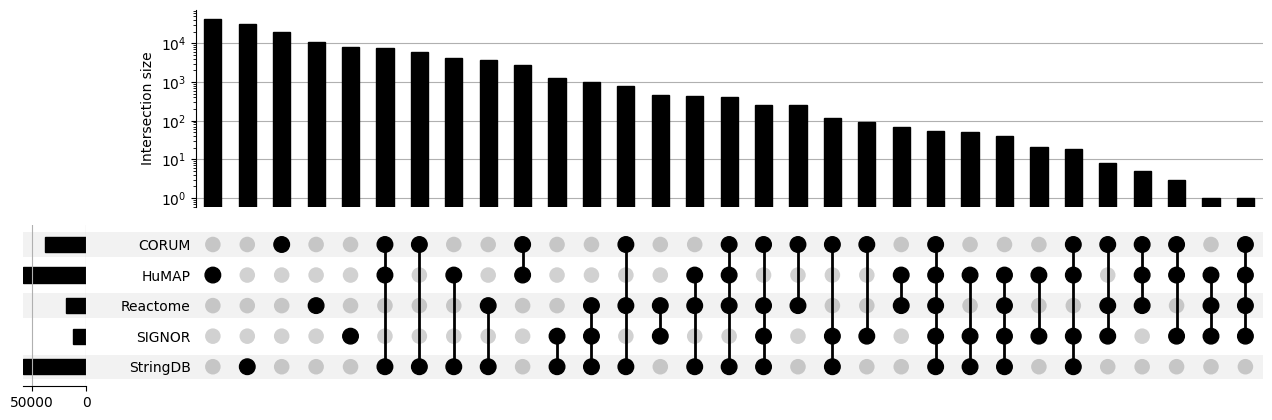

Union count: 143252
At least two count: 29600
All sources count: 54


In [4]:
benchmark_sources = {}
for src in BENCHMARK_SOURCES:
    res = pd.read_csv(f'../efaar_benchmarking/benchmark_annotations/{src}.txt')
    res = res[res.entity1 != res.entity2]
    res['sorted_entities'] = res.apply(lambda row: tuple(sorted([row['entity1'], row['entity2']])), axis=1)
    benchmark_sources[src] = set(res.sorted_entities)

upset_data = from_contents(benchmark_sources)
upset = UpSet(upset_data, sort_by='cardinality', sort_categories_by='-input')
upset.plot()
plt.yscale('log')
plt.show()

# Count the union of value sets
union_set = set()
for source in benchmark_sources.values():
    union_set.update(source)
union_count = len(union_set)

# Count the number of elements that are included in at least 2 sources
at_least_two_count = 0
for element in union_set:
    count = sum(element in source for source in benchmark_sources.values())
    if count >= 2:
        at_least_two_count += 1

# Count the number of elements that are included in all sources
all_sources_count = sum(all(element in source for source in benchmark_sources.values()) for element in union_set)

print('Union count:', union_count)
print('At least two count:', at_least_two_count)
print('All sources count:', all_sources_count)

## Check unfiltered cell count features in JUMP (Supp Fig 8)

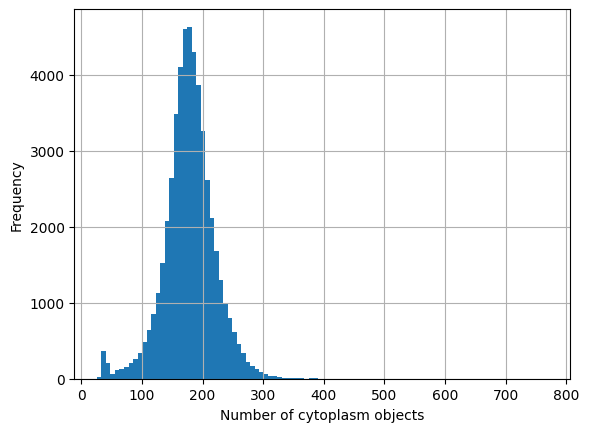

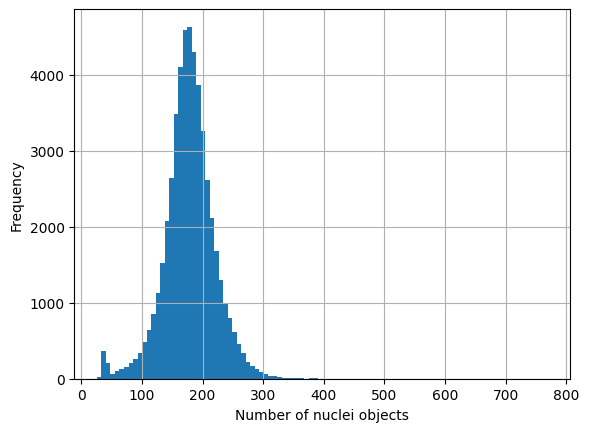

In [5]:
features, _ = load_cpg16_crispr()

features['Cytoplasm_Number_Object_Number'].hist(bins=100)
plt.xlabel('Number of cytoplasm objects')
plt.ylabel('Frequency')
plt.show()

features['Nuclei_Number_Object_Number'].hist(bins=100)
plt.xlabel('Number of nuclei objects')
plt.ylabel('Frequency')
plt.show()

## Identified protein complexes (Fig 6a)

9866 genes in the map
153 clusters are used from the benchmark source CORUM
6389 genes in the map
83 clusters are used from the benchmark source CORUM
15490 genes in the map
169 clusters are used from the benchmark source CORUM


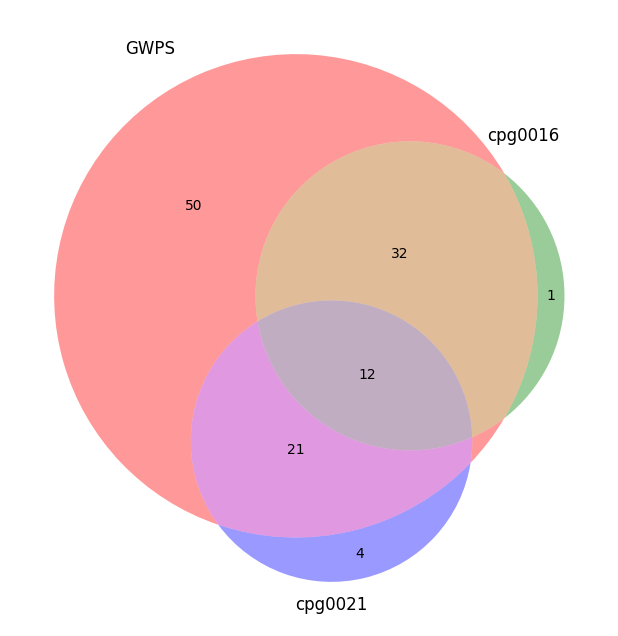

In [6]:
datasets = ['GWPS', 'cpg0016', 'cpg0021']
metdict = {dataset: cluster_benchmark(maps[dataset], pert_label_cols[dataset]) for dataset in datasets}
thr = .01
sigs = {}
for k, df in metdict.items():
    sigs[k] = set(df[df.ks_pval <= thr].cluster)

plt.figure(figsize=(8, 8))
venn3([sigs['GWPS'], sigs['cpg0016'], sigs['cpg0021']], set_labels=['GWPS', 'cpg0016', 'cpg0021'])
plt.show()

## Complexes identified by all datasets (Supp Table 3)

In [7]:
inter_set = set.intersection(*sigs.values())
all_pvals_inter = None
for m in datasets:
    tmp = metdict[m].loc[metdict[m].cluster.isin(inter_set)].sort_values('ks_pval')[['cluster', 'ks_pval', 'genes']].rename(columns={'ks_pval': f'pval_{m}', 'genes': f'genes_{m}'})
    if all_pvals_inter is None:
        all_pvals_inter = tmp
    else:
        all_pvals_inter = all_pvals_inter.merge(tmp, on='cluster', how='outer')
all_pvals_inter = all_pvals_inter.sort_values('cluster')
repres = all_pvals_inter[[x for x in all_pvals_inter.columns if 'genes' not in x]].copy().set_index('cluster').map(sig_level).rename(columns={f'pval_{x}': x for x in datasets})
print(repres)

                                                     GWPS cpg0016 cpg0021
cluster                                                                  
20S proteasome                                      *****   *****      **
BRCA1-core RNA polymerase II complex                *****   *****    ****
C complex spliceosome                               *****   *****   *****
DNA synthesome complex (13 subunits)                *****   *****      **
Mediator complex                                    *****   *****      **
Nop56p-associated pre-rRNA complex                  *****    ****   *****
PA28-20S proteasome                                 *****   *****      **
PA700-20S-PA28 complex                              *****   *****    ****
RNA polymerase II core complex                      *****   *****     ***
Respiratory chain complex I (beta subunit) mito...  *****     ***      **
Respiratory chain complex I (holoenzyme), mitoc...  *****   *****   *****
Spliceosome                           

## Heatmap of commonly identified complexes (Figure 6b)

<Figure size 3000x3000 with 0 Axes>

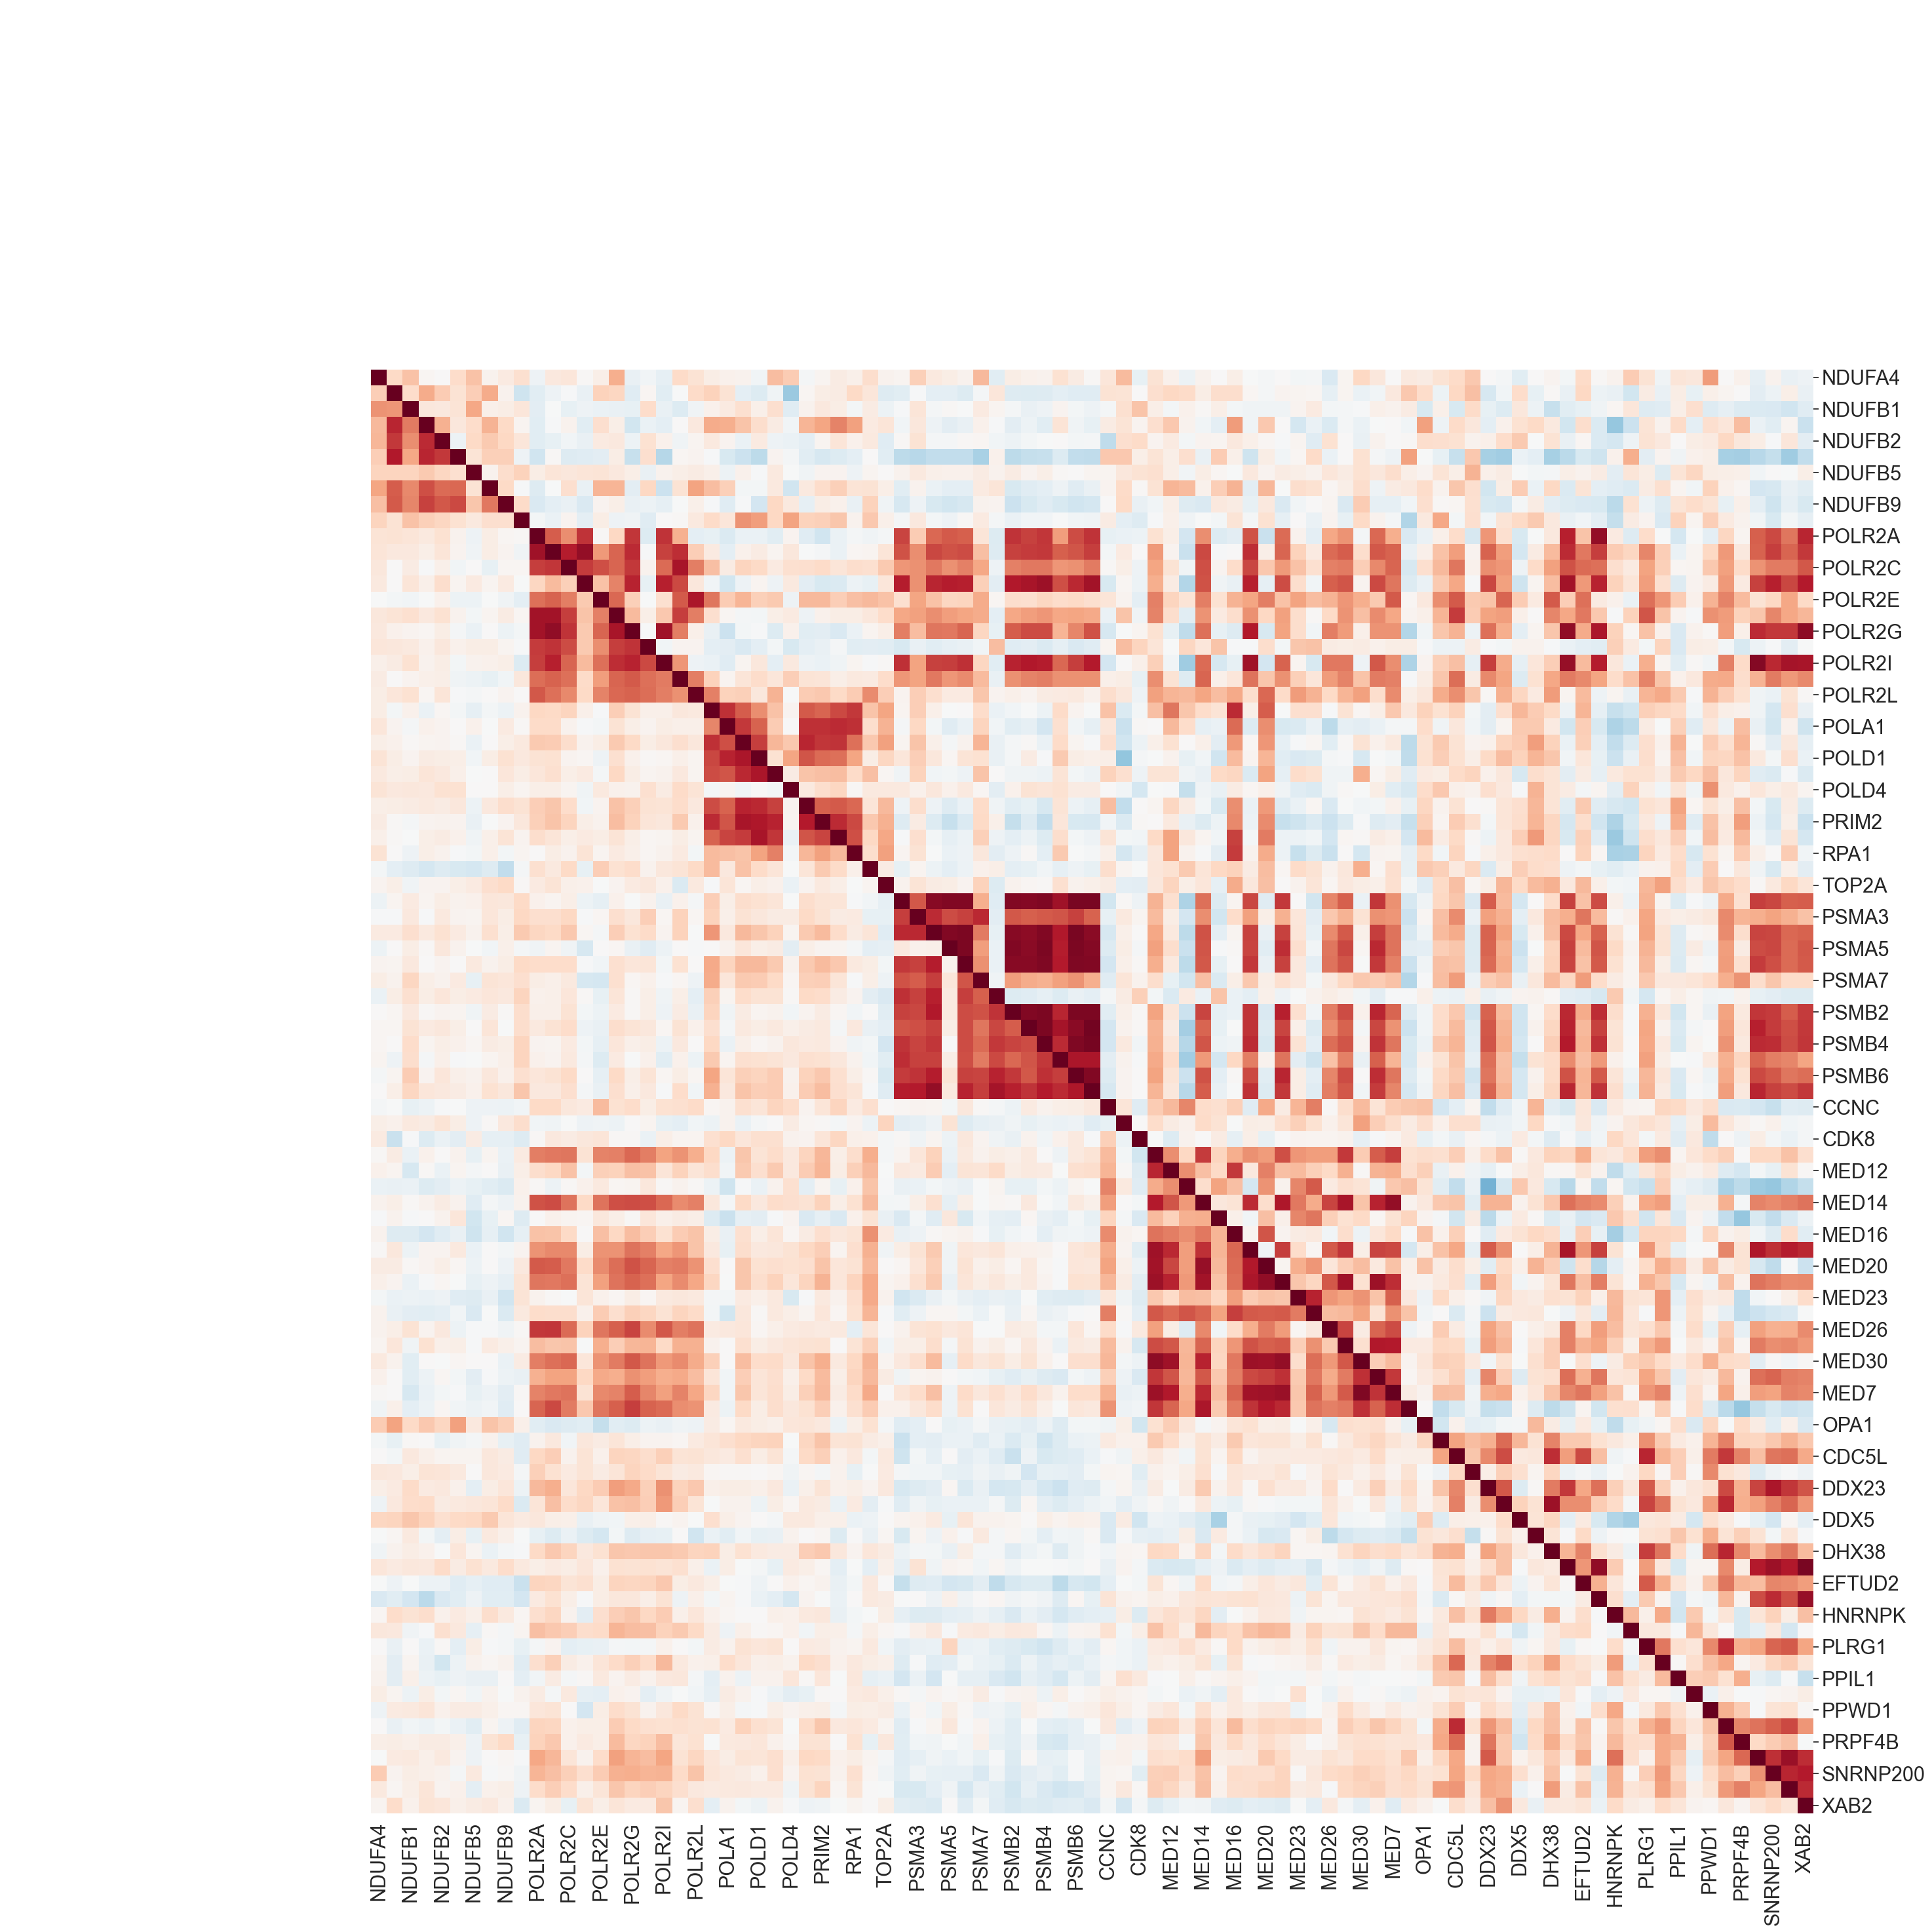

In [8]:
plot_heatmaps(all_pvals_inter, ['GWPS', 'cpg0016'])

## Save all dataset-exlusive identified complexes (Supp Tables 4,5,6)

In [9]:
for z in datasets:
    other_datasets = [x for x in datasets if x != z]
    print(z)
    union_sigs = set()
    for dataset in other_datasets:
        union_sigs.update(sigs[dataset])
    diff_set = sigs[z].difference(union_sigs)
    all_pvals_exlusive_z = None
    for m in datasets:
        tmp = metdict[m].loc[metdict[m].cluster.isin(diff_set)].sort_values('ks_pval')[['cluster', 'ks_pval', 'genes']].rename(columns={'ks_pval': f'pval_{m}', 'genes': f'genes_{m}'})
        if all_pvals_exlusive_z is None:
            all_pvals_exlusive_z = tmp
        else:
            all_pvals_exlusive_z = all_pvals_exlusive_z.merge(tmp, on='cluster', how='outer')
    all_pvals_exlusive_z = all_pvals_exlusive_z.sort_values('cluster')
    repres = all_pvals_exlusive_z[[x for x in all_pvals_exlusive_z.columns if 'genes' not in x]].copy().set_index('cluster').map(sig_level).rename(columns={f'pval_{x}': x for x in datasets})
    print(repres)

GWPS
                                                     GWPS cpg0016 cpg0021
cluster                                                                  
12S U11 snRNP                                       *****       -      ns
ALL-1 supercomplex                                   ****      ns       *
ATAC complex, YEATS2-linked                           ***       -      ns
BAF complex                                         *****      ns      ns
BASC complex (BRCA1-associated genome surveilla...    ***      ns      ns
BHC110 complex                                        ***       -      ns
BRG1-SIN3A complex                                  *****      ns      ns
BRG1-SIN3A-HDAC containing SWI/SNF remodeling c...  *****      ns      ns
BRM-SIN3A complex                                      **      ns       *
BRM-SIN3A-HDAC complex                              *****      ns      ns
BRM-associated complex                               ****      ns      ns
CENP-A NAC-CAD complex           

## Check GO enrichment of the top relationships for _C18orf21_ and _C1orf131_ in GWPS (Section 4.3.5)

In [10]:
dataset = 'GWPS'
src = "GO"
topx = 25
enr_p_lim = .01
for gene in ['C18orf21', 'C1orf131']:
    print(gene)
    res = compute_top_similars(maps[dataset], pert_label_cols[dataset], gene, topx=topx)
    print(', '.join(sorted(res.pert)))
    print(enrichment(res.pert, list(maps[dataset].metadata[pert_label_cols[dataset]]), source=src, pval_thr=enr_p_lim)[['cluster', 'pval']])
    print('\n')

C18orf21
ABT1, BYSL, CCDC59, DDX10, DDX21, DDX52, DIMT1, DKC1, FBXL14, GLB1, IMPA2, POP1, POP4, POP5, RPP14, RPP30, RPS19BP1, RRP7A, RRP9, SRFBP1, TBL3, UTP11, UTP23, WDR3, WDR36
5161 clusters are used from the benchmark source GO
                                              cluster          pval
0                            GOBP_RIBOSOME_BIOGENESIS  6.617382e-21
1                         GOBP_RRNA_METABOLIC_PROCESS  7.345121e-21
2                               GOBP_NCRNA_PROCESSING  8.526669e-21
3                        GOBP_NCRNA_METABOLIC_PROCESS  4.629976e-18
4           GOBP_RIBONUCLEOPROTEIN_COMPLEX_BIOGENESIS  7.150852e-18
5             GOBP_RIBOSOMAL_SMALL_SUBUNIT_BIOGENESIS  9.794908e-17
6                                 GOBP_RNA_PROCESSING  3.014815e-14
7                                    GOCC_PRERIBOSOME  1.694097e-12
8                                      GOCC_NUCLEOLUS  2.271825e-12
9                      GOCC_RIBONUCLEOPROTEIN_COMPLEX  1.826962e-11
10                   